In [1]:
!pip install pandas tqdm

In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta, timezone
from tqdm import tqdm

In [15]:
# --- Simulation Parameters ---
N_REFRIGERATORS = 100
SIMULATION_YEARS = 2
DATA_INTERVAL_MINUTES = 10
FAILURE_RATE = 0.05
DEGRADATION_PERIOD_DAYS = 60
LABELING_WINDOW_DAYS = 30

In [5]:
def generate_simulation_data():
    """
    Generates a large, labeled time-series dataset for a fleet of simulated refrigerators.
    (Corrected Version)
    """
    print("Starting data simulation...")

    # --- Setup Timeframe ---
    end_date = datetime.now(timezone.utc)
    start_date = end_date - timedelta(days=365 * SIMULATION_YEARS)

    # --- Create Fridge Metadata ---
    fridge_ids = [f"fridge_{i:03}" for i in range(N_REFRIGERATORS)]
    n_failing_fridges = int(N_REFRIGERATORS * FAILURE_RATE)

    failing_fridge_ids = random.sample(fridge_ids, k=n_failing_fridges)
    fridge_metadata = []

    print(f"\n{n_failing_fridges} refrigerators are programmed to fail.")

    for fridge_id in fridge_ids:
        is_failing = fridge_id in failing_fridge_ids
        failure_date = None
        if is_failing:
            failure_timestamp = random.uniform(
                (start_date + timedelta(days=DEGRADATION_PERIOD_DAYS + 90)).timestamp(),
                end_date.timestamp()
            )
            failure_date = datetime.fromtimestamp(failure_timestamp, tz=timezone.utc)

        fridge_metadata.append({
            "fridge_id": fridge_id,
            "is_failing": is_failing,
            "failure_date": failure_date,
            "ambient_noise": random.uniform(-1.5, 1.5) # FIX: Add unique noise for each fridge
        })

    df_meta = pd.DataFrame(fridge_metadata)
    all_data = []

    # --- Main Simulation Loop ---
    for _, fridge in tqdm(df_meta.iterrows(), total=df_meta.shape[0], desc="Simulating Refrigerators"):
        timestamp = start_date
        temp_setpoint = random.uniform(3.5, 4.5)

        while timestamp < end_date:
            days_to_failure = float('inf')
            if fridge['is_failing'] and pd.notna(fridge['failure_date']):
                days_to_failure = (fridge['failure_date'] - timestamp).total_seconds() / (24 * 3600)

            # --- Apply Degradation Logic ---
            degradation_factor = 0.0
            if 0 < days_to_failure <= DEGRADATION_PERIOD_DAYS:
                degradation_factor = 1 - (days_to_failure / DEGRADATION_PERIOD_DAYS)

            # --- Generate Sensor Readings ---
            temp_current = temp_setpoint + random.uniform(-0.5, 0.5)
            compressor_on = 1 if temp_current > temp_setpoint else 0

            temp_current += degradation_factor * 3.0
            compressor_duty_cycle_modifier = degradation_factor * 0.4
            if random.random() < compressor_duty_cycle_modifier:
                compressor_on = 1

            energy_kwh = (0.005 + degradation_factor * 0.005) if compressor_on else 0.0001
            door_open = random.choices([0, 1], weights=[99, 1], k=1)[0]
            voltage = random.uniform(225.0, 245.0)

            # FIX: Use the unique ambient noise for this fridge
            base_ambient_temp = 22.0 + (5 * np.sin(2 * np.pi * timestamp.timetuple().tm_yday / 365.25))
            ambient_temp = base_ambient_temp + fridge['ambient_noise']

            # --- Generate the Target Label (Corrected Logic) ---
            failed_in_next_30d = 1 if 0 < days_to_failure <= LABELING_WINDOW_DAYS else 0

            all_data.append({
                "fridge_id": fridge['fridge_id'],
                "timestamp": timestamp,
                "temperature_current_c": round(temp_current, 2),
                "compressor_on": compressor_on,
                "door_open": door_open,
                "energy_consumption_kwh": round(energy_kwh, 5),
                "voltage_v": round(voltage, 1),
                "ambient_temp_c": round(ambient_temp, 2),
                "failed_in_next_30d": failed_in_next_30d
            })

            timestamp += timedelta(minutes=DATA_INTERVAL_MINUTES)

    # --- Finalize Dataset ---
    print("\nFinalizing dataset...")
    df_final = pd.DataFrame(all_data)

    output_filename = "refrigerator_telemetry_data_v2.csv"
    df_final.to_csv(output_filename, index=False)
    print(f"Simulation complete. Dataset saved to '{output_filename}'.")
    print(f"Total data points generated: {len(df_final)}")

    # --- Verification Step ---
    print("\nVerification of the 'failed_in_next_30d' label distribution:")
    print(df_final['failed_in_next_30d'].value_counts())


if __name__ == "__main__":
    generate_simulation_data()

Starting data simulation...

5 refrigerators are programmed to fail.


Simulating Refrigerators: 100%|██████████| 100/100 [05:07<00:00,  3.08s/it]



Finalizing dataset...
Simulation complete. Dataset saved to 'refrigerator_telemetry_data_v2.csv'.
Total data points generated: 10512000

Verification of the 'failed_in_next_30d' label distribution:
failed_in_next_30d
0    10490400
1       21600
Name: count, dtype: int64


In [3]:
import pandas as pd
import random
from tqdm import tqdm
from datetime import timedelta, datetime, timezone
import os

In [4]:
INPUT_CSV = "/content/refrigerator_telemetry_data_v2.csv"
OUTPUT_CSV = "refrigerator_telemetry_smaller.csv"

# The period to extract for each failure event (should include degradation + labeling window)
FAILURE_WINDOW_DAYS = 90
# How many healthy fridges to include in the sample
N_HEALTHY_SAMPLES = 15
# How much data to take from each healthy fridge
HEALTHY_SAMPLE_DAYS = 90

def create_sampled_dataset():
    """
    Creates a smaller, high-value dataset by keeping all failure events
    and sampling a representative portion of healthy data.
    """
    print("--- Step 1: Loading Full Dataset (Memory Optimized) ---")

    try:
        dtype_map = {
            'temperature_current_c': 'float32', 'compressor_on': 'int8', 'door_open': 'int8',
            'energy_consumption_kwh': 'float32', 'voltage_v': 'float32',
            'ambient_temp_c': 'float32', 'failed_in_next_30d': 'int8'
        }
        df = pd.read_csv(INPUT_CSV, dtype=dtype_map, parse_dates=['timestamp'])
    except FileNotFoundError:
        print(f"Error: The file '{INPUT_CSV}' was not found.")
        print("Please run the 'create_dataset_v2.py' script first.")
        return

    df.sort_values(by=['fridge_id', 'timestamp'], inplace=True)
    print(f"Loaded {len(df)} total data points from {df['fridge_id'].nunique()} fridges.")

    # --- Step 2: Identify Failing and Healthy Fridges ---
    all_fridge_ids = set(df['fridge_id'].unique())
    failing_fridge_ids = set(df[df['failed_in_next_30d'] == 1]['fridge_id'].unique())
    healthy_fridge_ids = list(all_fridge_ids - failing_fridge_ids)

    print(f"\nFound {len(failing_fridge_ids)} failing fridges and {len(healthy_fridge_ids)} healthy fridges.")

    all_sampled_dfs = []

    # --- Step 3: Extract All Failure Events ---
    print(f"\nExtracting {FAILURE_WINDOW_DAYS}-day windows for all failure events...")
    for fridge_id in tqdm(failing_fridge_ids, desc="Processing Failing Fridges"):
        fridge_df = df[df['fridge_id'] == fridge_id]

        # Find the last moment the fridge was labeled for failure
        last_failure_label_time = fridge_df[fridge_df['failed_in_next_30d'] == 1]['timestamp'].max()

        # Extract the 90-day window leading up to that point
        start_date = last_failure_label_time - timedelta(days=FAILURE_WINDOW_DAYS)

        failure_window_df = fridge_df[(fridge_df['timestamp'] >= start_date) & (fridge_df['timestamp'] <= last_failure_label_time)]
        all_sampled_dfs.append(failure_window_df)

    # --- Step 4: Sample Healthy Data ---
    print(f"\nSampling {HEALTHY_SAMPLE_DAYS}-day windows from {N_HEALTHY_SAMPLES} healthy fridges...")
    sampled_healthy_ids = random.sample(healthy_fridge_ids, k=min(N_HEALTHY_SAMPLES, len(healthy_fridge_ids)))

    for fridge_id in tqdm(sampled_healthy_ids, desc="Processing Healthy Fridges"):
        fridge_df = df[df['fridge_id'] == fridge_id]

        # Pick a random start date for the sample, ensuring we can get a full 90-day chunk
        min_date = fridge_df['timestamp'].min()
        max_date = fridge_df['timestamp'].max() - timedelta(days=HEALTHY_SAMPLE_DAYS)

        if min_date >= max_date: continue

        random_start_seconds = random.uniform(min_date.timestamp(), max_date.timestamp())
        random_start_date = datetime.fromtimestamp(random_start_seconds, tz=timezone.utc)

        end_date = random_start_date + timedelta(days=HEALTHY_SAMPLE_DAYS)

        healthy_sample_df = fridge_df[(fridge_df['timestamp'] >= random_start_date) & (fridge_df['timestamp'] <= end_date)]
        all_sampled_dfs.append(healthy_sample_df)

    # --- Step 5: Combine, Shuffle, and Save ---
    print("\nCombining and saving the final sampled dataset...")
    final_df = pd.concat(all_sampled_dfs, ignore_index=True)

    # Shuffle the dataset to mix healthy and failing data
    final_df = final_df.sample(frac=1).reset_index(drop=True)

    final_df.to_csv(OUTPUT_CSV, index=False)

    print("\n--- Summary ---")
    print(f"Original dataset size: {len(df)} rows")
    print(f"New sampled dataset size: {len(final_df)} rows")
    print(f"New dataset size is ~{len(final_df)/len(df):.2%} of the original.")
    print("\nLabel distribution in the new dataset:")
    print(final_df['failed_in_next_30d'].value_counts())
    print(f"\nSampled dataset saved to '{OUTPUT_CSV}'.")


if __name__ == "__main__":
    create_sampled_dataset()

--- Step 1: Loading Full Dataset (Memory Optimized) ---
Loaded 1048575 total data points from 10 fridges.

Found 1 failing fridges and 9 healthy fridges.

Extracting 90-day windows for all failure events...


Processing Failing Fridges: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]



Sampling 90-day windows from 15 healthy fridges...


Processing Healthy Fridges: 100%|██████████| 9/9 [00:00<00:00, 10.25it/s]



Combining and saving the final sampled dataset...

--- Summary ---
Original dataset size: 1048575 rows
New sampled dataset size: 129601 rows
New dataset size is ~12.36% of the original.

Label distribution in the new dataset:
failed_in_next_30d
0    125281
1      4320
Name: count, dtype: int64

Sampled dataset saved to 'refrigerator_telemetry_smaller.csv'.


In [6]:
!pip install scikit-learn joblib

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from tqdm import tqdm
import os

In [6]:
INPUT_CSV = "/content/refrigerator_telemetry_smaller.csv"
OUTPUT_PATH = "."

In [7]:
TIMESTEPS_PER_HOUR = 60 // 10
HOURS_PER_DAY = 24
SEQUENCE_DAYS = 3
SEQUENCE_TIMESTEPS = SEQUENCE_DAYS * HOURS_PER_DAY * TIMESTEPS_PER_HOUR

In [8]:
def prepare_data_for_lstm():
    """
    Loads raw data in a memory-efficient way, scales it, creates sequences,
    and saves the final arrays. (Optimized Version)
    """

    # --- Step 1: Loading and Preprocessing Data (Optimized) ---
    print("--- Step 1: Loading and Preprocessing Data (Optimized) ---")

    try:
        # Define smaller data types to reduce memory usage during loading
        dtype_map = {
            'temperature_current_c': 'float32',
            'compressor_on': 'int8',
            'door_open': 'int8',
            'energy_consumption_kwh': 'float32',
            'voltage_v': 'float32',
            'ambient_temp_c': 'float32',
            'failed_in_next_30d': 'int8'
        }

        # Set a chunk size to process the large CSV file in pieces
        chunk_size = 100000
        df_chunks = []

        print(f"Reading '{INPUT_CSV}' in chunks of {chunk_size} rows...")

        # Create a tqdm progress bar for reading chunks
        file_size = os.path.getsize(INPUT_CSV)
        with open(INPUT_CSV, 'r') as f:
            # Get total lines for a more accurate progress bar
            total_lines = sum(1 for line in f)

        pbar = tqdm(total=total_lines, desc="Loading Chunks")
        for chunk in pd.read_csv(INPUT_CSV, dtype=dtype_map, chunksize=chunk_size):
            df_chunks.append(chunk)
            pbar.update(len(chunk))
        pbar.close()

        # Concatenate all chunks into a single DataFrame
        print("Concatenating chunks into a final DataFrame...")
        df = pd.concat(df_chunks, ignore_index=True)
        del df_chunks # Free up memory

    except FileNotFoundError:
        print(f"Error: The file '{INPUT_CSV}' was not found.")
        print("Please run the 'create_dataset_v2.py' script first.")
        return

    # Convert timestamp after loading and sort
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values(by=['fridge_id', 'timestamp'], inplace=True)

    print(f"Loaded {len(df)} data points.")
    df.info(memory_usage='deep')

    # --- Step 2: Scaling Features (No changes needed here) ---

    feature_columns = [
        'temperature_current_c', 'compressor_on', 'door_open',
        'energy_consumption_kwh', 'voltage_v', 'ambient_temp_c'
    ]

    print(f"\n--- Step 2: Scaling {len(feature_columns)} Features ---")

    scaler = MinMaxScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])

    os.makedirs(OUTPUT_PATH, exist_ok=True)
    scaler_filename = os.path.join(OUTPUT_PATH, "scaler.joblib")
    joblib.dump(scaler, scaler_filename)
    print(f"Scaler saved to '{scaler_filename}'.")

    # --- Step 3: Creating Sequences (No changes needed here) ---

    print(f"\n--- Step 3: Creating Sequences with {SEQUENCE_TIMESTEPS} Timesteps ---")

    sequences = []
    labels = []

    grouped_data = df.groupby('fridge_id')

    for fridge_id, fridge_data in tqdm(grouped_data, desc="Processing Fridges"):
        feature_data = fridge_data[feature_columns].values
        label_data = fridge_data['failed_in_next_30d'].values

        for i in range(len(feature_data) - SEQUENCE_TIMESTEPS):
            seq = feature_data[i:i + SEQUENCE_TIMESTEPS]
            label = label_data[i + SEQUENCE_TIMESTEPS - 1]

            sequences.append(seq)
            labels.append(label)

    X = np.array(sequences)
    y = np.array(labels)

    print("\n--- Step 4: Finalizing and Saving Data ---")
    print(f"Final shape of sequences (X): {X.shape}")
    print(f"Final shape of labels (y): {y.shape}")

    np.save(os.path.join(OUTPUT_PATH, "sequences.npy"), X)
    np.save(os.path.join(OUTPUT_PATH, "labels.npy"), y)

    print(f"\nData preparation complete. Model-ready files saved in '{OUTPUT_PATH}'.")
    print("You are now ready to train the LSTM model.")


if __name__ == "__main__":
    prepare_data_for_lstm()

--- Step 1: Loading and Preprocessing Data (Optimized) ---
Reading '/content/refrigerator_telemetry_smaller.csv' in chunks of 100000 rows...


Loading Chunks: 100%|█████████▉| 129601/129602 [00:00<00:00, 540175.33it/s]


Concatenating chunks into a final DataFrame...
Loaded 129601 data points.
<class 'pandas.core.frame.DataFrame'>
Index: 129601 entries, 26531 to 41715
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   fridge_id               129601 non-null  object             
 1   timestamp               129601 non-null  datetime64[ns, UTC]
 2   temperature_current_c   129601 non-null  float32            
 3   compressor_on           129601 non-null  int8               
 4   door_open               129601 non-null  int8               
 5   energy_consumption_kwh  129601 non-null  float32            
 6   voltage_v               129601 non-null  float32            
 7   ambient_temp_c          129601 non-null  float32            
 8   failed_in_next_30d      129601 non-null  int8               
dtypes: datetime64[ns, UTC](1), float32(4), int8(3), object(1)
memory usage: 11.6 MB

--- St

Processing Fridges: 100%|██████████| 10/10 [00:00<00:00, 100.86it/s]



--- Step 4: Finalizing and Saving Data ---
Final shape of sequences (X): (125281, 432, 6)
Final shape of labels (y): (125281,)

Data preparation complete. Model-ready files saved in '.'.
You are now ready to train the LSTM model.


In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import os

--- Step 0: Setup and GPU Check ---


--- Step 1: Loading Data and Splitting ---
Loading data using memory-mapping...
Data loaded with shapes: X=(125281, 432, 6), y=(125281,)
Training data shape: (100224, 432, 6)
Testing data shape: (25057, 432, 6)

--- Step 2: Creating tf.data.Dataset Pipeline ---
TensorFlow data pipelines created.

--- Step 3: Calculating Class Weights ---
Calculated class weights: {0: np.float64(0.5178517913794707), 1: np.float64(14.504196816208394)}

--- Step 4: Building and Compiling the LSTM Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)


--- Step 5: Training the Model ---
Epoch 1/10
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 424s 269ms/step - accuracy: 0.9873 - loss: 0.1170 - precision: 0.7519 - recall: 0.9477 - val_accuracy: 0.9958 - val_loss: 0.0136 - val_precision: 0.8907 - val_recall: 1.0000
Epoch 2/10
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 426s 272ms/step - accuracy: 0.9928 - loss: 0.0206 - precision: 0.8305 - recall: 0.9971 - val_accuracy: 0.9954 - val_loss: 0.0115 - val_precision: 0.8825 - val_recall: 1.0000
Epoch 3/10
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 469s 300ms/step - accuracy: 0.9947 - loss: 0.0133 - precision: 0.8668 - recall: 0.9977 - val_accuracy: 0.9992 - val_loss: 0.0022 - val_precision: 0.9763 - val_recall: 1.0000
Epoch 4/10
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 483s 288ms/step - accuracy: 0.9947 - loss: 0.0152 - precision: 0.8689 - recall: 0.9985 - val_accuracy: 0.9980 - val_loss: 0.0049 - val_precision: 0.9473 - val_recall: 0.9988
Epoch 5/10
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 524s 302ms/step - accuracy: 0.9924 - loss: 0.0218 - precis

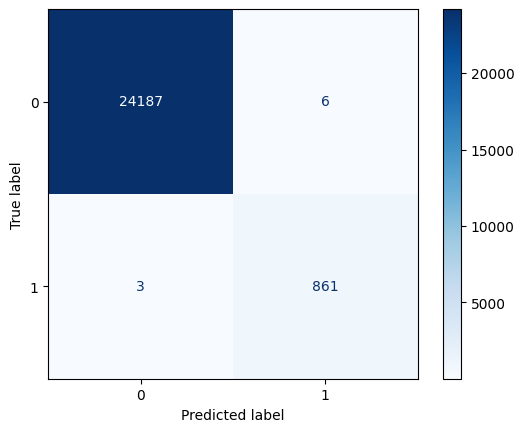

In [10]:
# --- Step 0: Setup and GPU Check ---
print("--- Step 0: Setup and GPU Check ---")
# (Same as before)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('\nWARNING: GPU device not found.')
else:
  print('\nSUCCESS: Found GPU at: {}'.format(device_name))


# --- Step 1: Load Data (Memory-Mapped) and Split ---
print("\n--- Step 1: Loading Data and Splitting ---")
X_FILE = '/content/sequences.npy'
Y_FILE = '/content/labels.npy'

if not os.path.exists(X_FILE) or not os.path.exists(Y_FILE):
    print(f"Error: Make sure '{X_FILE}' and '{Y_FILE}' are uploaded.")
else:
    # Use mmap_mode='r' to avoid loading the entire file into RAM at once.
    # This treats the file on disk as if it were an in-memory array.
    print("Loading data using memory-mapping...")
    X = np.load(X_FILE, mmap_mode='r')
    y = np.load(Y_FILE, mmap_mode='r')

    print(f"Data loaded with shapes: X={X.shape}, y={y.shape}")

    # Create indices for splitting, then create views of the data.
    # This avoids copying large amounts of data in memory.
    indices = np.arange(X.shape[0])
    train_indices, test_indices = train_test_split(
        indices, test_size=0.2, random_state=42, stratify=y
    )

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")


# --- Step 2: Create tf.data.Dataset Pipeline ---
print("\n--- Step 2: Creating tf.data.Dataset Pipeline ---")
BATCH_SIZE = 64

# Create TensorFlow datasets from the NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Create a highly efficient data pipeline
# This shuffles, batches, and prefetches data to the GPU in the background
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("TensorFlow data pipelines created.")


# --- Step 3: Handle Class Imbalance ---
print("\n--- Step 3: Calculating Class Weights ---")
# (This step remains the same)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Calculated class weights: {class_weight_dict}")


# --- Step 4: Build and Compile the LSTM Model ---
print("\n--- Step 4: Building and Compiling the LSTM Model ---")
# (This step remains the same)
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(64, input_shape=input_shape),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
model.summary()


# --- Step 5: Train the Model using the Dataset Pipeline ---
print("\n--- Step 5: Training the Model ---")

# The only change here is passing the tf.data.Dataset objects
# instead of the raw NumPy arrays. TensorFlow handles the streaming.
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    class_weight=class_weight_dict
)


# --- Step 6: Evaluate the Model ---
print("\n--- Step 6: Evaluating Model Performance ---")
# (This step remains the same)
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [11]:
model.save('sequences.h5')

In [12]:
MODEL_FILE = '/content/sequences.h5'
SCALER_FILE = '/content/scaler.joblib'

In [13]:
TIMESTEPS_PER_HOUR = 60 // 10
HOURS_PER_DAY = 24
SEQUENCE_DAYS = 3
SEQUENCE_TIMESTEPS = SEQUENCE_DAYS * HOURS_PER_DAY * TIMESTEPS_PER_HOUR
N_FEATURES = 6 # The number of raw features

In [17]:
def generate_sample_sequence(is_failing=False):
    """
    Generates a sample sequence of raw data for inference.
    If is_failing is True, it simulates data from a degrading fridge.
    """
    print(f"\nGenerating a sample {'FAILING' if is_failing else 'HEALTHY'} data sequence...")
    raw_data = []
    timestamp = datetime.now(timezone.utc) - timedelta(minutes=SEQUENCE_TIMESTEPS * 10)
    temp_setpoint = 4.0

    for i in range(SEQUENCE_TIMESTEPS):
        degradation_factor = 0.0
        if is_failing:
            # Simulate being in the last 3 days of a 60-day degradation period
            degradation_factor = 1 - ((SEQUENCE_TIMESTEPS - i) / (DEGRADATION_PERIOD_DAYS * HOURS_PER_DAY * TIMESTEPS_PER_HOUR))
            degradation_factor = max(0.5, degradation_factor) # Ensure degradation is significant

        temp_current = temp_setpoint + random.uniform(-0.5, 0.5) + (degradation_factor * 2.5)
        compressor_on = 1 if temp_current > temp_setpoint else 0
        if random.random() < (degradation_factor * 0.3):
            compressor_on = 1

        raw_data.append({
            "temperature_current_c": temp_current,
            "compressor_on": compressor_on,
            "door_open": 0,
            "energy_consumption_kwh": (0.005 + degradation_factor * 0.005) if compressor_on else 0.0001,
            "voltage_v": random.uniform(225.0, 245.0),
            "ambient_temp_c": 22.5
        })
        timestamp += timedelta(minutes=10)

    print(raw_data)

    return raw_data

def run_inference(raw_data_sequence):
    """
    Loads the model and scaler, preprocesses the data, and returns a prediction.
    """
    # --- 1. Load Model and Scaler ---
    try:
        model = keras.models.load_model(MODEL_FILE)
        scaler = joblib.load(SCALER_FILE)
    except Exception as e:
        print(f"Error loading model or scaler: {e}")
        return

    # --- 2. Pre-process the Input Data ---
    # Convert to DataFrame
    df = pd.DataFrame(raw_data_sequence)
    feature_columns = [
        'temperature_current_c', 'compressor_on', 'door_open',
        'energy_consumption_kwh', 'voltage_v', 'ambient_temp_c'
    ]
    df = df[feature_columns] # Ensure correct column order

    # Scale the features using the loaded scaler
    scaled_features = scaler.transform(df)

    # Reshape into the 3D format the LSTM expects: (1, timesteps, features)
    sequence = np.array([scaled_features])

    if sequence.shape != (1, SEQUENCE_TIMESTEPS, N_FEATURES):
        print(f"Error: Input data has incorrect shape {sequence.shape}")
        return

    # --- 3. Run Prediction ---
    prediction_proba = model.predict(sequence)[0][0]

    # --- 4. Display Results ---
    risk_score = float(prediction_proba)
    is_failure_imminent = bool(risk_score > 0.5)

    print("\n--- Inference Result ---")
    print(f"Model Prediction: '{'Failure Imminent' if is_failure_imminent else 'Normal Operation'}'")
    print(f"Failure Risk Score: {risk_score:.4f}")
    print("----------------------")


if __name__ == "__main__":
    # --- Test with a HEALTHY sample ---
    healthy_sequence = generate_sample_sequence(is_failing=False)
    run_inference(healthy_sequence)

    # --- Test with a FAILING sample ---
    failing_sequence = generate_sample_sequence(is_failing=True)
    run_inference(failing_sequence)


Generating a sample HEALTHY data sequence...
[{'temperature_current_c': 3.935697700386555, 'compressor_on': 0, 'door_open': 0, 'energy_consumption_kwh': 0.0001, 'voltage_v': 240.52033979085866, 'ambient_temp_c': 22.5}, {'temperature_current_c': 3.5844391964301754, 'compressor_on': 0, 'door_open': 0, 'energy_consumption_kwh': 0.0001, 'voltage_v': 233.9324772731791, 'ambient_temp_c': 22.5}, {'temperature_current_c': 3.8543762588356394, 'compressor_on': 0, 'door_open': 0, 'energy_consumption_kwh': 0.0001, 'voltage_v': 229.05184150443165, 'ambient_temp_c': 22.5}, {'temperature_current_c': 4.402098927842526, 'compressor_on': 1, 'door_open': 0, 'energy_consumption_kwh': 0.005, 'voltage_v': 234.9697306247503, 'ambient_temp_c': 22.5}, {'temperature_current_c': 4.103634172684014, 'compressor_on': 1, 'door_open': 0, 'energy_consumption_kwh': 0.005, 'voltage_v': 231.85065099845033, 'ambient_temp_c': 22.5}, {'temperature_current_c': 4.41879177168822, 'compressor_on': 1, 'door_open': 0, 'energy_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step



--- Inference Result ---
Model Prediction: 'Normal Operation'
Failure Risk Score: 0.0000
----------------------

Generating a sample FAILING data sequence...
[{'temperature_current_c': 6.560167473241678, 'compressor_on': 1, 'door_open': 0, 'energy_consumption_kwh': 0.00975, 'voltage_v': 231.44298053833, 'ambient_temp_c': 22.5}, {'temperature_current_c': 6.045900979277936, 'compressor_on': 1, 'door_open': 0, 'energy_consumption_kwh': 0.009750578703703704, 'voltage_v': 235.04124657604237, 'ambient_temp_c': 22.5}, {'temperature_current_c': 6.7875069723649695, 'compressor_on': 1, 'door_open': 0, 'energy_consumption_kwh': 0.009751157407407408, 'voltage_v': 242.7254631198927, 'ambient_temp_c': 22.5}, {'temperature_current_c': 6.445572922837163, 'compressor_on': 1, 'door_open': 0, 'energy_consumption_kwh': 0.00975173611111111, 'voltage_v': 236.57056027326465, 'ambient_temp_c': 22.5}, {'temperature_current_c': 6.238350992797983, 'compressor_on': 1, 'door_open': 0, 'energy_consumption_kwh': 0.